In [38]:
# Standard library imports
import math
import os
import random
import time
from numbers import Number

# Related third party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.gridspec import GridSpec
import scipy.spatial.distance
from scipy.spatial.distance import cosine
from torch.utils.data import Dataset, DataLoader

# Local application/library specific imports
import numpy.linalg
import numpy.random as npr
import torch.jit

NEURON_COUNT = 300

### notes
latent variable in the input w/ a penalization when too high
this is like an autoencoder w/ input as neural activity
batch w multiple worms -> latent var since neurons r diff -> after output compress into 100 (?) or the compare w neural activity

use behavior (continuous) and use this as input; expand into 302; add auxilliary latent var -> recurrent layer
-> output (instead of reproducing behavior repro ncural actiity)
this might incorporate the things neural activ nity as input doesn't include
actually predicting something (behav -> neural activity)

try w/ latent var and without
try w randomly connected recurrent & w/ conectome matrix

neuropal
use one with 115 / 152 tracked and just use that to impact the loss function

aggregate the neuropal id'ed worms

isntead of multiple worms; batch on diff timepoints from one worm (like 16000 timesteps; use 1000 and 16 batches )

# function definitions

In [3]:
def pearson_similarity(matrix1, matrix2):
    flat_matrix1 = matrix1.flatten()
    flat_matrix2 = matrix2.flatten()

    correlation = np.corrcoef(flat_matrix1, flat_matrix2)[0, 1]
    return correlation


In [4]:
def noise_white_noise(num_neurons,num_time_steps,mean,std_dev,seed):
    np.random.seed(seed)
    white_noise = np.random.normal(mean, std_dev, size=(num_neurons, num_time_steps))

    return torch.tensor(white_noise, dtype=torch.float32)


In [5]:
# Initialize the connectivity matrix for the both RNN
def generate_connectivity(num_neurons, seed=132):
    np.random.seed(seed)
    W = 1/np.sqrt(num_neurons) * np.random.normal(0, 1., (num_neurons,num_neurons))  ### I added a 1/np.sqrt(num_neuron) to avoid SV too large
    np.fill_diagonal(W, 0)     # Remove self-connection because people have told me they give off weird dynamics

    return torch.tensor(W, dtype=torch.float32)

# runs VAE inference on the neurons

assuming the neurons are known are
`python main.py --neuron_holdout "['SAADR', 'IL1R', 'AWAR', 'ASGL', 'IL1VR', 'CEPVR', 'RMEV', 'RMDR', 'AIBR', 'AWBR', 'AIZL', 'AUAL', 'AIZR', 'AVJR', 'AIBL', 'ASEL', 'SIA?L', 'I2R', 'URBR', 'SAAVL', 'IL2DL', 'IL1DL', 'IL2VR', 'OLQVR', 'URXL', 'CEPDL', 'SMDDL', 'AVJL', 'ASKL', 'AVDR', 'NSMR', 'RIVL', 'URADL', 'FLPL', 'OLQDR', 'RIBL', 'RIH', 'M5', 'AIYL', 'AVAR', 'FLPR', 'SMDDR', 'I2L', 'AVL', 'SMBVR', 'M3L', 'RMED', 'AVER', 'IL2L', 'BAGR', 'ADEL', 'ADAL', 'OLQVL', 'RIAL', 'AVAL', 'AIML', 'ASHL', 'RMDDL', 'RICR', 'NSML', 'AIMR', 'SMDVL', 'AINL', 'SMBDR', 'VB02', 'AWCL', 'SMBDL', 'AVK?', 'URXR', 'MCR', 'RMER', 'RICL', 'RMFL', 'RIVR', 'M3R', 'URBL', 'ASGR', 'URYVL', 'RID', 'RIM?', 'AWBL', 'RMDDR', 'IL1DR', 'I3', 'I1R', 'URADR', 'URYDR', 'RMDL', 'SMDVR', 'RMEL', 'SAAVR', 'M4', 'RMGL', 'OLLL', 'IL2R', 'RIPL', 'AVHL', 'CEPDR', 'IL2DR', 'URYVR', 'IL2VL', 'AVDL', 'CEPVL', 'MCL', 'BAGL', 'MI', 'RIAR', 'OLLR', 'AUAR', 'URYDL', 'IL1L', 'AVEL', 'OLQDL', 'SAADL' ]" --model_type current --constraint sparsity --random_init_index 0`

from the given connectivity matrix

In [ ]:
# Example: Loading a model checkpoint
# checkpoint_path = 'checkpoints/your_checkpoint_file.pt'
# network.load_state_dict(torch.load(checkpoint_path))
# network.eval()  # Set the model to evaluation mode

network.load_state_dict(torch.load('path_to_checkpoint.pt'))
network.eval()


In [ ]:
# Example: Loading new data
new_data_loader = ...  # Create a DataLoader for new input data

with torch.no_grad():
    for new_odor_input, new_target_padding, new_missing_padding in new_data_loader:
        outputs = network.forward(
            fluorescence_full_target=new_target_padding,
            fluorescence_target=new_target,
            missing_target_mask=new_missing_padding,
            odor_input=new_odor_input,
            is_Training=False
        )
        predicted_activity = outputs['predicted_activity']
        # Process and analyze the predicted_activity as needed



# neural activity

In [39]:
def generate_training_activity(num_neurons, time_steps, connectivity):

    ### external input/noise generation for the activity -- this will be learned by the noise parameter in the RNN
    inputWN = noise_white_noise(num_neurons, time_steps, mean=0.5,std_dev=0.5, seed=123).numpy()

    # Initialize the connectivity matrix for the teacher RNN
    # W = generate_connectivity(num_neurons, seed=103)
    W = connectivity

    # Initialize the initial state of each neuron
    state = np.random.randn(num_neurons)

    # Initialize the initial activity from 0 for each neuron
    activity = np.zeros((time_steps, num_neurons))

    # generating activity state at each time step
    for t in range(time_steps):
        state = np.tanh(np.dot(W, state)+ inputWN[:,t])  ### try linear
        activity[t] = state

    return torch.tensor(activity, dtype=torch.float32)

torch.Size([1000, 300])


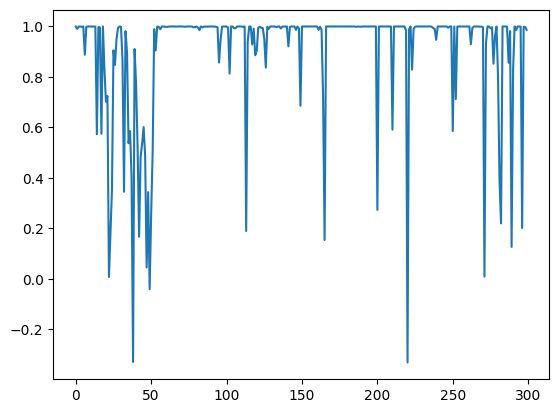

In [43]:
activity = generate_training_activity(NEURON_COUNT, 1000, connectivity)
plt.plot(activity[40].numpy())
print(activity.shape)

In [8]:
def load_neural_activity(file_path):
	with open(file_path, 'r') as f:
		data = json.load(f)
	
	activity = data["trace_array"]
	# avg_timestep = data['avg_timestep']
	act_tensor = torch.tensor(activity, dtype=torch.float32)
	num_neurons = data["num_neurons"]
	# print(data["labeled"], type(data["labeled"]))
	labeled = {}
	for key, value in data["labeled"].items():
		index = int(key)
		label = str(value["label"])
		labeled[label] = torch.tensor(activity[index-1], dtype=torch.float32)
	print(num_neurons)

	time_steps = act_tensor.shape[1]

	if num_neurons < NEURON_COUNT: 
		# random values similar to generate activity
		rand_act = torch.randn(NEURON_COUNT-num_neurons, time_steps)
		print(rand_act)
		act_tensor = torch.cat((act_tensor, rand_act), dim=0)
		print(act_tensor.shape)
		# num_neurons = NEURON_COUNT

	# upper_quartile = torch.kthvalue(act_tensor, int(0.75 * act_tensor.numel()), dim=0)[0]
	# lower_quartile = torch.kthvalue(act_tensor, int(0.25 * act_tensor.numel()), dim=0)[0]
	# IQR = upper_quartile - lower_quartile
	# lower_bound = lower_quartile - IQR * 1.5
	# # outlier_factor * IQR
	# upper_bound = upper_quartile + 1.5 * IQR
	# excl_outliers = data[(data >= lower_bound) & (data <= upper_bound)]

	# # Calculate the min and max values excluding outliers
	# min_val = np.min(excl_outliers)
	# max_val = np.max(excl_outliers)

	# # Normalize values based on the excluding-outliers range
	# normalized_tensor = (excl_outliers - min_val) / (max_val - min_val)

	# act_tensor = torch.tanh(normalized_tensor)

	return act_tensor.T, labeled, num_neurons

In [9]:
activity_file = "data/2022-08-02-01.json"
activity, labeled, num_neurons = load_neural_activity(activity_file)
# print(activity.shape)
# print(activity)

print(labeled.keys())

152
tensor([[-0.3782,  0.9064, -1.0977,  ..., -2.1072, -1.0780, -1.5066],
        [ 3.0397,  1.2057, -0.9707,  ...,  1.2410, -0.7632, -1.6582],
        [-0.2806, -0.6019,  1.8554,  ..., -0.7340, -0.5367,  0.8589],
        ...,
        [-1.3791, -0.5537, -1.6013,  ...,  0.7520,  0.0269,  0.2224],
        [-0.4407,  0.7194, -1.4142,  ..., -0.6341,  0.1932, -0.4748],
        [ 0.0801, -0.5148, -0.2812,  ..., -0.3216, -0.9811, -0.7342]])
torch.Size([302, 1600])
dict_keys(['SAADR', 'IL1R', 'AWAR', 'ASGL', 'IL1VR', 'CEPVR', 'RMEV', 'RMDR', 'AIBR', 'AWBR', 'AIZL', 'AUAL', 'AIZR', 'AVJR', 'AIBL', 'ASEL', 'SIA?L', 'I2R', 'URBR', 'SAAVL', 'IL2DL', 'IL1DL', 'IL2VR', 'OLQVR', 'URXL', 'CEPDL', 'SMDDL', 'AVJL', 'ASKL', 'AVDR', 'NSMR', 'RIVL', 'URADL', 'FLPL', 'OLQDR', 'RIBL', 'RIH', 'M5', 'AIYL', 'AVAR', 'FLPR', 'SMDDR', 'I2L', 'AVL', 'SMBVR', 'M3L', 'RMED', 'AVER', 'IL2L', 'BAGR', 'ADEL', 'ADAL', 'OLQVL', 'RIAL', 'AVAL', 'AIML', 'ASHL', 'RMDDL', 'RICR', 'NSML', 'AIMR', 'SMDVL', 'AINL', 'SMBDR', 'VB

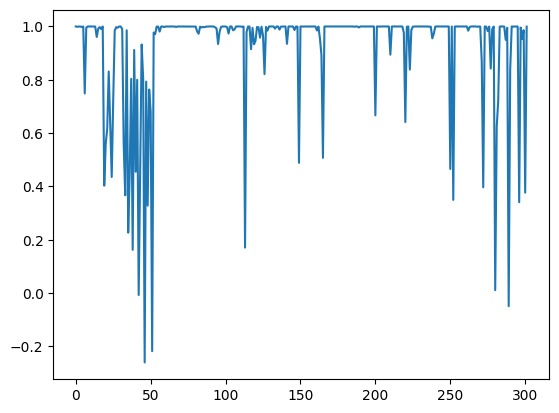

[-0.07385784539145593, 0.16534691260886838, 0.4733905696696592, 0.710179970497083, 0.6672458575539394, 0.7006858615884356, 0.6791412718213155, 0.6373643933083772, 0.7210214081483978, 0.7078601364824959, 0.6860007211213419, 0.6232465518222218, 0.6590404062926867, 0.6829863568147369, 0.680492516790507, 0.7527392791940674, 0.6127268506322169, 0.6661852210420631, 0.6779504254650213, 0.5922792573591719, 0.6022446752875954, 0.7004036253027935, 0.7918577593399443, 0.691325538234442, 0.625521181536307, 0.6989188909694303, 0.731399065404707, 0.7007750219927568, 0.6127997255078802, 0.6313212919442549, 0.6112356368633547, 0.7896399220405671, 0.5169742875064389, 0.7391136617822286, 0.6308972374828609, 0.7033731301897641, 0.6579539017591995, 0.702798088133389, 0.6644293070712999, 0.7193731470946498, 0.7170977374977776, 0.7112036880542587, 0.6746098262010467, 0.6962348222675208, 0.6456972889567173, 0.6726840859247145, 0.7647461060628697, 0.6475496523989804, 0.6099543307885312, 0.7841364707134576, 0.

In [41]:
# Plot the numpy array using pyplot
# for i in range(5):
plt.plot(activity[200].numpy())
plt.show()

similarity = []

for i in range(300):
	similarity.append(pearson_similarity(activity[i].numpy(), activity[300-i].numpy()))

print(similarity)

# Show the plot

In [14]:


def connectome_loader(file_path, rows=338, cols_to_use=304):
	df = pd.read_excel(file_path, nrows=rows, usecols=cols_to_use)

	# Extract the first row and first column as labels
	row_labels = df.iloc[1:, 0].tolist()
	print(row_labels)
	col_labels = df.columns[1:].tolist()
	print(col_labels)

	print(len(row_labels), len(col_labels))

	# Get the actual data excluding the title row and column
	data = df.iloc[1:, 1:] 
	print(data)
	# .astype(float)

	# Initialize an empty tensor with dimensions (number of rows, number of columns)
	num_rows = len(row_labels)
	num_cols = len(col_labels)
	tensor = np.zeros((num_rows, num_cols), dtype=np.float32)
	# Fill the tensor based on the DataFrame
	for i in range(num_rows):
		for j in range(num_cols):
			if pd.notna(data.iat[i, j]):
				tensor[i, j] = 1 # data.iat[i, j] / data.max().max()
			else:
				tensor[i, j] = 0
	print(tensor.shape)
	# Create a dictionary to map labels to tensor indices
	label_to_index_row = {label: idx for idx, label in enumerate(row_labels)}
	label_to_index_col = {label: idx for idx, label in enumerate(col_labels)}

	# Display the connection matrix with labels
	connection_matrix = pd.DataFrame(tensor, index=row_labels, columns=col_labels)

	return torch.tensor(tensor), label_to_index_row, label_to_index_col, connection_matrix # not sure if we need anything else other than tensor but just to be safe


In [42]:

file_path = 'data/gap_synapse_adjacency_matrix_filtered.xlsx' 
cols = "A:LZ"

connectivity, rows, cols, frame = connectome_loader(file_path, NEURON_COUNT+1, range(NEURON_COUNT+1))


['I1R', 'I2L', 'I2R', 'I3', 'I4', 'I5', 'I6', 'M1', 'M2L', 'M2R', 'M3L', 'M3R', 'M4', 'M5', 'MCL', 'MCR', 'MI', 'NSML', 'NSMR', 'pm1', 'pm2D', 'pm2VL', 'pm2VR', 'pm3D', 'pm3VL', 'pm3VR', 'pm4D', 'pm4VL', 'pm4VR', 'pm5D', 'pm5VL', 'pm5VR', 'pm6D', 'pm6VL', 'pm6VR', 'pm7D', 'pm7VL', 'pm7VR', 'pm9', 'mc1DL', 'mc1DR', 'mc1V', 'mc2DL', 'mc2DR', 'mc2V', 'mc3DL', 'mc3DR', 'mc3V', 'e2D', 'e2VL', 'e2VR', 'e3D', 'e3VL', 'e3VR', 'g1AL', 'g1AR', 'ASIL', 'ASIR', 'ASJL', 'ASJR', 'AWAL', 'AWAR', 'ASGL', 'ASGR', 'AWBL', 'AWBR', 'ASEL', 'ASER', 'ADFL', 'ADFR', 'AFDL', 'AFDR', 'AWCL', 'AWCR', 'ASKL', 'ASKR', 'ASHL', 'ASHR', 'ADLL', 'ADLR', 'BAGL', 'BAGR', 'URXL', 'URXR', 'ALNL', 'ALNR', 'PLNL', 'PLNR', 'SDQL', 'SDQR', 'AQR', 'PQR', 'ALML', 'ALMR', 'AVM', 'PVM', 'PLML', 'PLMR', 'FLPL', 'FLPR', 'DVA', 'PVDL', 'PVDR', 'ADEL', 'ADER', 'PDEL', 'PDER', 'PHAL', 'PHAR', 'PHBL', 'PHBR', 'PHCL', 'PHCR', 'IL2DL', 'IL2DR', 'IL2L', 'IL2R', 'IL2VL', 'IL2VR', 'CEPDL', 'CEPDR', 'CEPVL', 'CEPVR', 'URYDL', 'URYDR', 'URYV

In [15]:
print(torch.max(connectivity))

tensor(1.)


^^ instead maybe write function that loads worm data

# RNN model

In [45]:
class SE1:
    def __init__(self, se1=0.01, neuron_num=300, network_structure=(5, 5, 4), coordinates_list=None, distance_power=1, distance_metric='euclidean'):
        self.distance_power = distance_power
        self.se1 = torch.tensor(se1, dtype=torch.float32)

        # Setup coordinates
        nx, ny, nz = np.arange(network_structure[0]), np.arange(network_structure[1]), np.arange(network_structure[2])
        x, y, z = np.meshgrid(nx, ny, nz)
        self.coordinates = [x.ravel(), y.ravel(), z.ravel()]

        if coordinates_list:
            self.coordinates = coordinates_list

        if not all(len(coord) == neuron_num for coord in self.coordinates):
            raise ValueError('Network/coordinate structure does not match the number of neurons.')

        euclidean_vector = scipy.spatial.distance.pdist(np.transpose(self.coordinates), metric=distance_metric)
        euclidean = scipy.spatial.distance.squareform(euclidean_vector ** self.distance_power)
        self.distance_matrix = euclidean.astype('float32')
        self.distance_tensor = torch.tensor(self.distance_matrix)

    def __call__(self, weight_matrix):
        abs_weight_matrix = torch.abs(weight_matrix)
        se1_loss = self.se1 * torch.sum(abs_weight_matrix * self.distance_tensor)
        return se1_loss

    def visualise_distance_matrix(self):
        plt.imshow(self.distance_matrix)
        plt.colorbar()
        plt.show()

    def visualise_neuron_structure(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(*self.coordinates, c='b', marker='.')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.show()


In [20]:
# Define the RNN model
class SimpleRNN(nn.Module):
	def __init__(self, noise, input_size, hidden_size, output_size, connectivity_matrix, distance_tensor):
		super(SimpleRNN, self).__init__()
		self.rnn = nn.RNN(input_size, hidden_size,batch_first=True)
		self.fc = nn.Linear(hidden_size, output_size)
		self.input_size = input_size
		self.hidden_size = hidden_size
		self.output_size = output_size
		
		# # Input to hidden layer
		# self.W_xh = nn.Linear(input_size, hidden_size, bias=False)
		
		# # Hidden to hidden layer
		# self.W_hh = nn.Linear(hidden_size, hidden_size, bias=False)
		

## I want each input activity to go directly into hidden layer of that neuron and not do some densely connected layer stuff
## And I also want to freeze the input layer so it does not update.
		self.rnn.weight_ih_l0.data = torch.eye(input_size, hidden_size)
		self.rnn.weight_ih_l0.requires_grad = False
		self.rnn.bias_ih_l0.data.fill_(0.0)
		self.rnn.bias_ih_l0.requires_grad = False


## creating the student RNN connectivity matrix, in the current instance, I am giving it the student network a percentage of teacher
## connectivity matrix W, determined previously by the mask, and the rest will be filled in with the random matrix.
		
		# Apply the connectivity matrix
		# with torch.no_grad():
		#     self.rnn.weight_hh_l0.data.copy_(self.rnn.weight_hh_l0.data * connectivity_matrix)
		
		self.rnn.weight_hh_l0.data *= connectivity_matrix
		# generate_connectivity(input_size, seed=132)
		self.rnn.weight_hh_l0.requires_grad = True
		self.rnn.bias_hh_l0.data.fill_(0.0)
		self.rnn.bias_hh_l0.requires_grad = False

## Similarly to input, I want each hidden activity to go directly into output layer of that neuron and not do some densely connected layer stuff
## And I also want to freeze the output layer so it does not update.
		self.fc.weight.data = torch.eye(hidden_size, output_size)  # Set to 1
		self.fc.weight.requires_grad = False  # Freeze weights
		self.fc.bias.data.fill_(0.0)
		self.fc.bias.requires_grad = False

### Lastly, I will add noise as a parameter to account for the external input during my teacher network activity generation
		self.noise = nn.Parameter(noise)
		self.noise.requires_grad = True
		
		self.distance_tensor = distance_tensor # seRNN

	def forward(self, x):
		x = x + self.noise # noise to input
		h0 = torch.zeros(1, x.size(0), self.hidden_size) ### Initialize hidden state
		out, _ = self.rnn(x, h0)
		out = self.fc(out)

		# h0 = torch.zeros(1, x.size(0), self.hidden_size) ### Initialize hidden state
		# out, _ = self.rnn(x, h0)
		# out = self.fc(out+ self.noise)
		#KPK yes. Different network.

		return out
		
	def calculate_structural_loss(self):
		# Calculate the structural se1 loss
		W = self.rnn.weight_hh_l0
		abs_weight_matrix = torch.abs(W)
		se1_loss = torch.sum(abs_weight_matrix * self.distance_tensor)
		return se1_loss

In [46]:
def simulate_rnn(num_neurons,time_steps,alpha, connectivity_matrix):

    # The input, hidden and output are all set to num_neurons
    input_size = num_neurons
    # hidden_size = num_neurons
    hidden_size = connectivity_matrix.shape[0] 
    output_size = num_neurons
    
    # Initialize the SE1 regularizer
    se1_regularizer = SE1(se1=0.01, neuron_num=num_neurons, network_structure=(5, 6, 10))
    distance_tensor = se1_regularizer.distance_tensor

    # generating activity state at each time step
    activity_tensor = generate_training_activity(num_neurons, time_steps, connectivity_matrix)
    noise = noise_white_noise(num_neurons, time_steps, mean=0.5,std_dev=0.5, seed=156).t()
    model = SimpleRNN(noise, input_size, hidden_size, output_size, connectivity_matrix, distance_tensor)
    student_init = model.rnn.weight_hh_l0.data.numpy().copy() ## record the initial student connectivity matrix before training
    noise_init = model.noise.data.numpy().copy() ## record the initial noise before training
    

    criterion = nn.MSELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.003)

    # training data, the input and target should be the same since I want student to replicate teacher
    input_seq = activity_tensor.unsqueeze(0)
    target_seq = activity_tensor.unsqueeze(0)


    num_epochs = 100


    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        start_time = time.time()
        output = model(input_seq)
        real_loss = criterion(output, target_seq) # I just wanna see what is the actual fit without seeing the noise loss
        loss = criterion(output, target_seq) + alpha* torch.sum(torch.abs(model.noise)) ### regularize noise L1
        # Calculate structural loss
        structural_loss = model.calculate_structural_loss()
        
        # Total loss
        total_loss = loss + structural_loss
        
        total_loss.backward() # we do backprop on the totla loss, including the structual information
        # loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        # Compute the running loss every 1000 steps
        # if epoch % 100 == 99:
        print('real_loss {:0.4f}, Time {:0.1f}s'.format(real_loss, time.time() - start_time))
        print('Noise {:0.4f}, Time {:0.1f}s'.format(torch.sum(torch.abs(noise)), time.time() - start_time))

        # Print loss
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Task Loss: {loss.item():.4f}, Structural Loss: {structural_loss.item():.4f}, Total Loss: {total_loss.item():.4f}')

        with torch.no_grad():
            model.rnn.weight_hh_l0.fill_diagonal_(0)  ### making sure the diagonal of the learned student connectivity also has no self-connections


    # Extract the learned student weights
    student_learned = model.rnn.weight_hh_l0.data.numpy()
    noise_out = model.noise.data.numpy().copy() ## record the noise after training

    model.eval()
    with torch.no_grad():
      generated_activity = model(input_seq).detach().squeeze(0).numpy()


    return generated_activity, activity_tensor, student_learned, student_init, noise, noise_init, noise_out

In [22]:

file_path = 'data/gap_synapse_adjacency_matrix_filtered.xlsx' 
cols = "A:LZ"

connectivity, rows, cols, frame = connectome_loader(file_path, NEURON_COUNT+1, range(NEURON_COUNT+1))

['I1R', 'I2L', 'I2R', 'I3', 'I4', 'I5', 'I6', 'M1', 'M2L', 'M2R', 'M3L', 'M3R', 'M4', 'M5', 'MCL', 'MCR', 'MI', 'NSML', 'NSMR', 'pm1', 'pm2D', 'pm2VL', 'pm2VR', 'pm3D', 'pm3VL', 'pm3VR', 'pm4D', 'pm4VL', 'pm4VR', 'pm5D', 'pm5VL', 'pm5VR', 'pm6D', 'pm6VL', 'pm6VR', 'pm7D', 'pm7VL', 'pm7VR', 'pm9', 'mc1DL', 'mc1DR', 'mc1V', 'mc2DL', 'mc2DR', 'mc2V', 'mc3DL', 'mc3DR', 'mc3V', 'e2D', 'e2VL', 'e2VR', 'e3D', 'e3VL', 'e3VR', 'g1AL', 'g1AR', 'ASIL', 'ASIR', 'ASJL', 'ASJR', 'AWAL', 'AWAR', 'ASGL', 'ASGR', 'AWBL', 'AWBR', 'ASEL', 'ASER', 'ADFL', 'ADFR', 'AFDL', 'AFDR', 'AWCL', 'AWCR', 'ASKL', 'ASKR', 'ASHL', 'ASHR', 'ADLL', 'ADLR', 'BAGL', 'BAGR', 'URXL', 'URXR', 'ALNL', 'ALNR', 'PLNL', 'PLNR', 'SDQL', 'SDQR', 'AQR', 'PQR', 'ALML', 'ALMR', 'AVM', 'PVM', 'PLML', 'PLMR', 'FLPL', 'FLPR', 'DVA', 'PVDL', 'PVDR', 'ADEL', 'ADER', 'PDEL', 'PDER', 'PHAL', 'PHAR', 'PHBL', 'PHBR', 'PHCL', 'PHCR', 'IL2DL', 'IL2DR', 'IL2L', 'IL2R', 'IL2VL', 'IL2VR', 'CEPDL', 'CEPDR', 'CEPVL', 'CEPVR', 'URYDL', 'URYDR', 'URYV

In [47]:
# Generate the activity from the trained student RNN
generated_activity, activity_tensor, student_learned, student_init, noise, noise_init, noise_out = simulate_rnn(num_neurons = NEURON_COUNT, time_steps=100,alpha=0.001, connectivity_matrix=connectivity)


real_loss 0.0560, Time 1.0s
Noise 17322.9531, Time 1.0s
real_loss 0.0432, Time 0.2s
Noise 17255.7344, Time 0.2s
real_loss 0.0396, Time 0.1s
Noise 17197.5996, Time 0.1s
real_loss 0.1322, Time 0.2s
Noise 17144.3555, Time 0.2s
real_loss 0.1737, Time 0.1s
Noise 17094.1172, Time 0.1s
real_loss 0.1556, Time 0.2s
Noise 17045.8418, Time 0.2s
real_loss 0.1048, Time 0.3s
Noise 16998.8887, Time 0.3s
real_loss 0.0529, Time 0.7s
Noise 16952.8340, Time 0.7s
real_loss 0.0411, Time 0.1s
Noise 16907.3906, Time 0.1s
real_loss 0.0421, Time 0.2s
Noise 16862.3027, Time 0.2s
Epoch [10/100], Task Loss: 16.9494, Structural Loss: 327.8735, Total Loss: 344.8230
real_loss 0.0539, Time 0.3s
Noise 16817.4277, Time 0.3s
real_loss 0.0607, Time 0.4s
Noise 16772.6562, Time 0.4s
real_loss 0.0554, Time 1.1s
Noise 16727.8789, Time 1.1s
real_loss 0.0548, Time 0.8s
Noise 16683.0078, Time 0.8s
real_loss 0.0589, Time 0.1s
Noise 16638.0156, Time 0.1s
real_loss 0.0529, Time 1.2s
Noise 16592.9258, Time 1.2s
real_loss 0.0440, Ti

In [48]:
print(generated_activity)

[[0.91377544 0.92289394 0.7575215  ... 0.28308502 0.6973091  0.5385495 ]
 [0.6499855  0.9050751  0.76789695 ... 0.6668032  0.9412826  0.7918329 ]
 [0.7683108  0.8751798  0.9071325  ... 0.8447703  0.93906695 0.78362334]
 ...
 [0.894362   0.80146176 0.7797875  ... 0.8067804  0.76406765 0.94742095]
 [0.9624954  0.86266637 0.8307254  ... 0.7796016  0.85221833 0.91400164]
 [0.77431107 0.77991366 0.92246664 ... 0.9148666  0.8798511  0.9476657 ]]


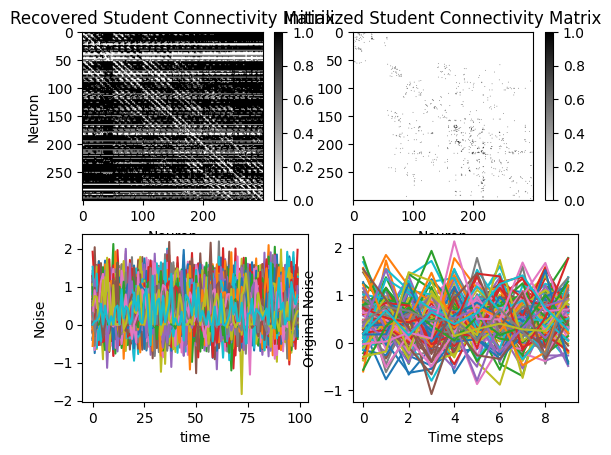

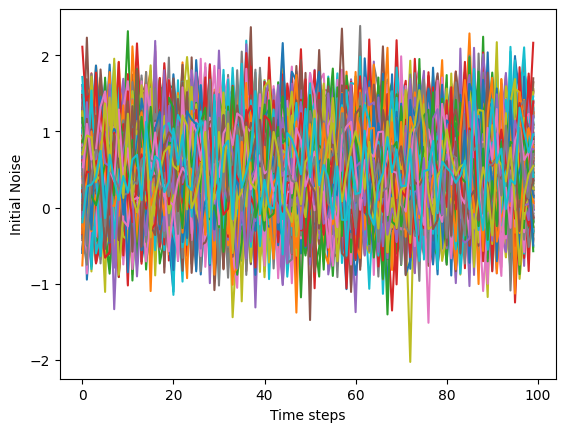

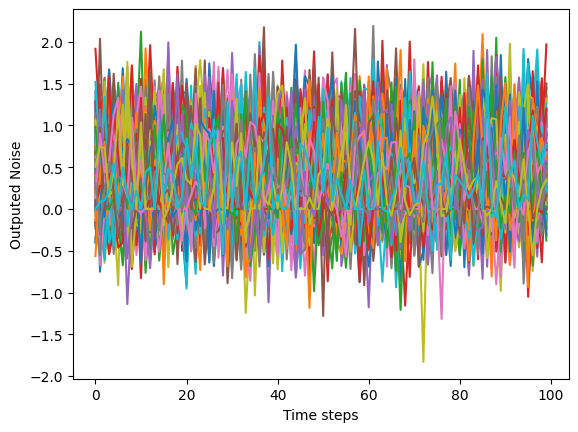

<Figure size 640x480 with 0 Axes>

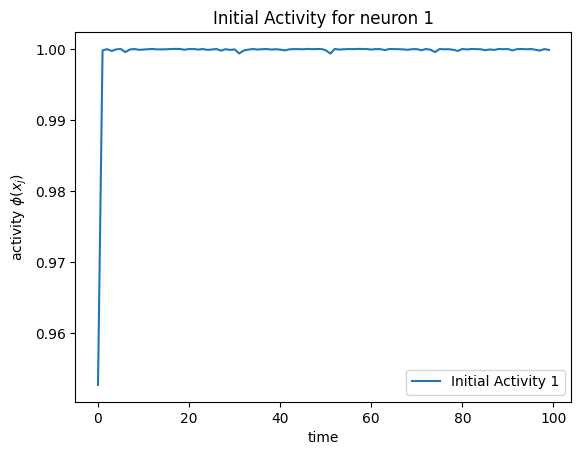

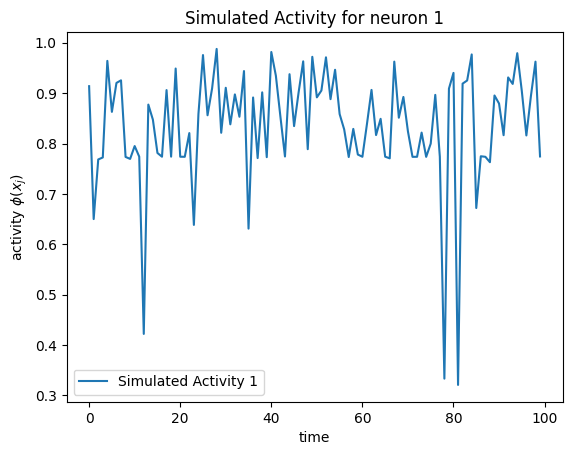

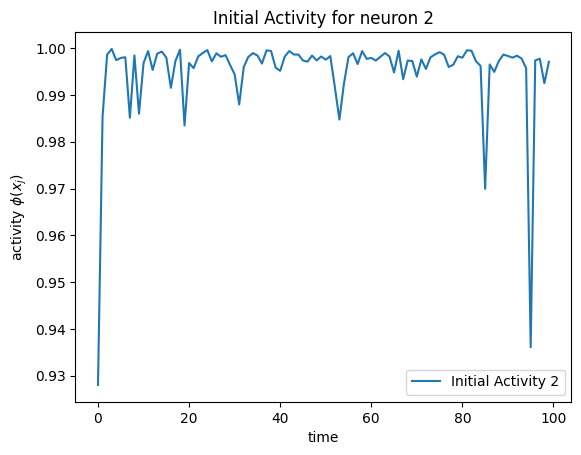

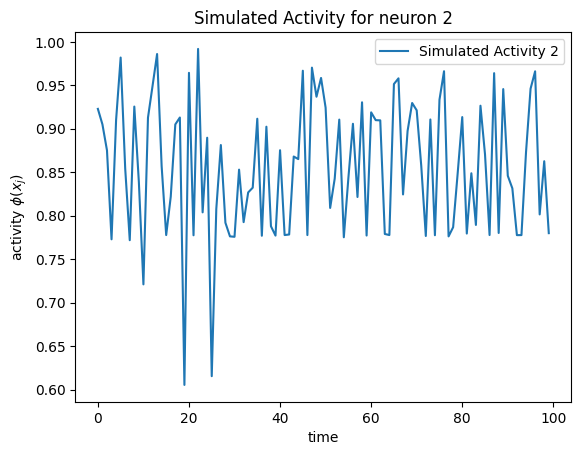

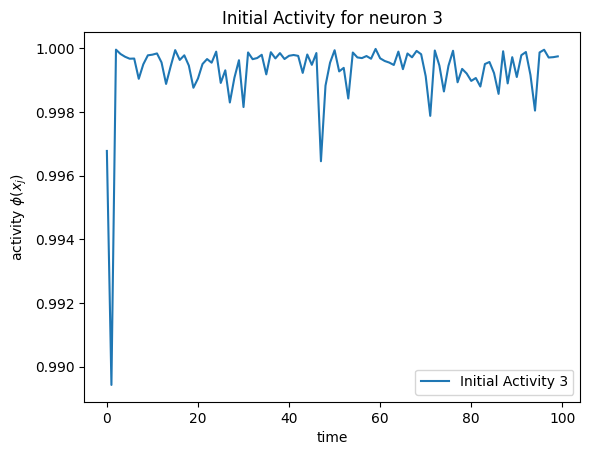

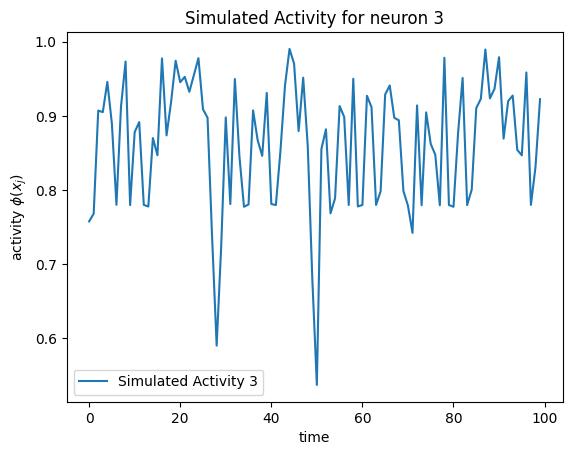

In [49]:
time_steps = 100
time_tot = np.arange(time_steps)

### Plot relevant graphs

# Plot 2 -- binarized student learned connectivity matrix
plt.subplot(2, 2, 1)
plt.imshow(np.where(student_learned > 0, 1, 0), cmap='binary', aspect='auto')
plt.colorbar()
plt.title('Recovered Student Connectivity Matrix')
plt.xlabel('Neuron')
plt.ylabel('Neuron')

# Plot 3 -- binarized student initial connectivity matrix
plt.subplot(2, 2, 2)
plt.imshow(np.where(student_init > 0, 1, 0), cmap='binary', aspect='auto')
plt.colorbar()
plt.title('Initialized Student Connectivity Matrix')
plt.xlabel('Neuron')

# Plot 4 -- noise profile after training data
plt.subplot(2, 2, 3)
plt.plot(time_tot, noise, label='Noise')
plt.xlabel('time')
plt.ylabel('Noise')

plt.subplot(2, 2, 4)
plt.plot(noise_white_noise(10, 100, mean=0.5,std_dev=0.5, seed=111))
plt.xlabel('Time steps')
plt.ylabel('Original Noise')
plt.show()

# plt.subplot(2, 2, 5)
plt.plot(time_tot, noise_init, label="Noise Initial")
plt.xlabel('Time steps')
plt.ylabel('Initial Noise')
plt.show()


plt.plot(time_tot, noise_out, label="Noise Output")
plt.xlabel('Time steps')
plt.ylabel('Outputed Noise')
plt.show()


plt.tight_layout()
plt.show()

for i in range(3):
    plt.figure()
    plt.plot(time_tot, activity_tensor[:, i], label=f'Initial Activity {i+1}')
    plt.xlabel('time')
    plt.ylabel(r'activity $\phi(x_j)$')
    plt.legend()
    plt.title(f'Initial Activity for neuron {i+1}')
    plt.show()

    plt.figure()
    plt.plot(time_tot, generated_activity[:, i], label=f'Simulated Activity {i+1}')
    plt.xlabel('time')
    plt.ylabel(r'activity $\phi(x_j)$')
    plt.legend()
    plt.title(f'Simulated Activity for neuron {i+1}')
    plt.show()

In [50]:
W = connectivity
# W = generate_connectivity(num_neurons=302, seed=103)
# print(student_learned)
print(pearson_similarity(W, student_learned))
print(pearson_similarity(W, student_init))
print(pearson_similarity(student_learned, student_init))

-0.021007956613861893
-0.006596620425473408
0.005977611089562086
